# Phase 1 – ML-based IDS on Train_Test_IoT_Modbus

This notebook implements **Phase 1** of the experimental design described in the paper *“Cyber Threats in IIoT: Can ML Mitigate Vulnerabilities and Prevent Harm?”*. The goal of this phase is to use the official `Train_Test_IoT_Modbus` subset of the ToN_IoT dataset as a relatively balanced and manageable environment to design and tune three classical ML models:

- **Decision Trees (DT)**
- **Random Forests (RF)**
- **Support Vector Machines (SVM)**

The focus is strictly on **IIoT sensor telemetry** from a Modbus-based service. Each record contains four Modbus function-code counters (`FC1_Read_Input_Register`, `FC2_Read_Discrete_Value`, `FC3_Read_Holding_Register`, `FC4_Read_Coil`) and two labels:

- `label`: binary flag (`0 = normal`, `1 = attack`)
- `type`: traffic / attack category (`normal`, `injection`, `backdoor`, `password`, `scanning`, `xss`)

Within this phase, the notebook addresses two related learning tasks:

1. **Binary intrusion detection** – distinguish *normal* vs *malicious* records using `label`.
2. **Multiclass intrusion classification** – discriminate between *normal* traffic and the five Modbus attack categories using `type`.

The work in this notebook is organised as follows:

1. **Data loading and initial exploration** of the `Train_Test_IoT_Modbus.csv` file (shape, feature types, class distributions).
2. **Data preparation and Train/validation/test splitting**: definition of feature matrices and target vectors for both the binary and multiclass tasks. Stratification on the multiclass labels, in order to preserve the attack-type distribution across all splits.
3. **Feature preprocessing**: standardisation of the four Modbus counters, with the scaler fitted only on the training split to avoid information leakage.
4. **Model training and hyperparameter tuning** for DT, RF, and SVM using the validation set.
5. **Model selection** based on macro-averaged F1-score and inspection of false negative rates per attack category.
6. **Final evaluation** of the best configuration on the held-out test set.

In **Phase 2**, implemented in a separate notebook, the best-performing configurations obtained here will be re-evaluated on the full `IoT_Modbus` processed dataset, which preserves the original, highly imbalanced distribution of normal and attack records. This two-phase structure is intended to show how models that perform well on a “laboratory” subset behave when faced with a more realistic IIoT scenario.

**Note:** For all `.ipynb` files, I used LLM assistance. I asked it to explain each step of the process, provide markdown commentary, and offer limited guidance whenever I lost track of the workflow.

##1. Data loading and initial exploration

In this first step, I load the `Train_Test_IoT_Modbus.csv` file and perform a basic exploratory analysis.  
The goal is to confirm the shape of the dataset, inspect the data types of each column, and understand the overall class distribution before defining the ML tasks.


In [71]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# Load the Train_Test_IoT_Modbus subset
df = pd.read_csv("Train_Test_IoT_Modbus.csv")

# Quick check
print("Shape:", df.shape)
df.head()


Shape: (31106, 8)


,date,time,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil,label,type
0,25-Apr-19,09:14:00,49389,52921,25770,13625,1,injection
1,25-Apr-19,09:14:00,49389,52921,25770,13625,1,injection
2,25-Apr-19,09:14:01,49389,52921,25770,13625,1,injection
3,25-Apr-19,09:14:02,49389,52921,25770,13625,1,injection
4,25-Apr-19,09:14:04,40665,44748,21098,35371,1,injection


The `Train_Test_IoT_Modbus.csv` file loads correctly into a Pandas dataframe with the following shape:

- **31,106 rows** (individual observations)
- **8 columns**:

  - `date`, `time`: timestamp of each record.
  - `FC1_Read_Input_Register`, `FC2_Read_Discrete_Value`, `FC3_Read_Holding_Register`, `FC4_Read_Coil`: integer Modbus counters.
  - `label`: binary indicator of normal vs. attack traffic.
  - `type`: traffic / attack category.

The first rows confirm that all four Modbus features are present for each record, together with both labels (`label` and `type`).


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31106 entries, 0 to 31105
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   date                       31106 non-null  object
 1   time                       31106 non-null  object
 2   FC1_Read_Input_Register    31106 non-null  int64 
 3   FC2_Read_Discrete_Value    31106 non-null  int64 
 4   FC3_Read_Holding_Register  31106 non-null  int64 
 5   FC4_Read_Coil              31106 non-null  int64 
 6   label                      31106 non-null  int64 
 7   type                       31106 non-null  object
dtypes: int64(5), object(3)
memory usage: 1.9+ MB


The `info()` summary shows that:

- All **31,106 entries are non-null** in every column, so there are no missing values to handle.
- The four Modbus features and the `label` column are stored as **64-bit integers**.
- `date`, `time` and `type` are stored as Python `object` (string) types.

For the purposes of this phase, the focus is on the four Modbus counters as numerical features, while `date` and `time` are treated as metadata and are not used as predictive variables. The `type` column will later be encoded as categorical labels for the multiclass classification task.


In [57]:
df[["FC1_Read_Input_Register",
    "FC2_Read_Discrete_Value",
    "FC3_Read_Holding_Register",
    "FC4_Read_Coil",
    "label"]].describe()

,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil,label
count,31106.000000,31106.000000,31106.000000,31106.000000,31106.000000
mean,32833.925834,32781.719733,32582.861859,32805.957468,0.517778
std,18827.079410,18969.443025,18858.863346,18796.567682,0.499692
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16764.000000,16658.500000,16419.250000,16509.000000,0.000000
50%,32310.000000,32692.000000,32155.000000,32776.000000,1.000000
75%,49088.000000,49235.000000,48881.000000,49011.000000,1.000000
max,65510.000000,65535.000000,65523.000000,65534.000000,1.000000


The descriptive statistics of the four Modbus counters and the binary label are as follows:

- Each feature has **31,106 valid values**, matching the total number of records.
- The four Modbus counters have means around **32,000–33,000**  
  (`FC1 ≈ 32,834`, `FC2 ≈ 32,782`, `FC3 ≈ 32,583`, `FC4 ≈ 32,806`) and standard deviations in the range of **18,800–19,000**, indicating substantial variability in Modbus activity.
- All counters take values between **0** and roughly **65,500**, with the 25th percentile around **16,400–16,800** and the 75th percentile around **48,800–49,200**. This suggests that low and high Modbus-traffic regimes coexist in the dataset.
- The `label` column has a mean of approximately **0.518** and a standard deviation of **0.50**, which is consistent with a slightly higher proportion of attack records than normal records (close to a 52% vs. 48% split). The 25th percentile is `0` and the 75th percentile is `1`, confirming the expected binary structure.

Overall, these statistics confirm that the Modbus features are well-formed numeric variables with wide dynamic ranges, and that the dataset is only mildly imbalanced at the binary level, even though the attack proportion is higher than what would be expected in a typical real-world IIoT deployment.


In [58]:
print("Label distribution (0 = normal, 1 = attack):")
print(df["label"].value_counts())

print("\nAttack type distribution:")
print(df["type"].value_counts())


Label distribution (0 = normal, 1 = attack):
label
1    16106
0    15000
Name: count, dtype: int64

Attack type distribution:
type
normal       15000
injection     5000
backdoor      5000
password      5000
xss            577
scanning       529
Name: count, dtype: int64


The label distribution is as follows:

- `label = 0` (normal): **15,000** records  
- `label = 1` (attack): **16,106** records  

This means that the dataset is only slightly skewed towards attack traffic (about 48% normal vs. 52% attack), which is convenient for model training and comparison but clearly more attack-heavy than a realistic IIoT deployment.

The `type` column refines the picture:

- `normal`: 15,000 samples  
- `injection`: 5,000  
- `backdoor`: 5,000  
- `password`: 5,000  
- `xss`: 577  
- `scanning`: 529  

Most attack types (`injection`, `backdoor`, `password`) are **artificially balanced** at 5,000 samples each, while `xss` and `scanning` appear as **minority attack classes** with fewer than 600 instances.  

This structure confirms that `Train_Test_IoT_Modbus` is a curated, almost balanced benchmark: it is ideal for comparing ML models under controlled conditions, but it does **not** reflect the true rarity of attacks in production IIoT systems. This limitation will be explicitly addressed in Phase 2, when evaluating the same models on the full, highly imbalanced `IoT_Modbus` dataset.

## Extra step for curiousity
###Modbus function-code counters

In this step I perform a first exploratory analysis of the four Modbus function-code counters available in the `Train_Test_IoT_Modbus` subset:

- `FC1_Read_Input_Register`
- `FC2_Read_Discrete_Value`
- `FC3_Read_Holding_Register`
- `FC4_Read_Coil`

The goal is to understand their basic behaviour in the dataset and to check whether they carry any obvious discriminative signal with respect to the binary label (`normal` vs. `attack`). To this end, I present a summary of statistics and the correlation matrix between the four counters.


In [59]:
features = ["FC1_Read_Input_Register",
            "FC2_Read_Discrete_Value",
            "FC3_Read_Holding_Register",
            "FC4_Read_Coil"]

df.groupby("label")[features].agg(["mean", "std", "median"])


FC1_Read_Input_Register                        FC2_Read_Discrete_Value  \
                         mean           std   median                    mean   
label                                                                          
0                33026.042133  18749.375297  32470.0            33131.288867   
1                32655.002173  18897.985689  32220.0            32456.155532   

                             FC3_Read_Holding_Register                         \
                std   median                      mean           std   median   
label                                                                           
0      19057.529776  32993.0              32763.955733  18775.161223  32605.0   
1      18881.807730  32429.5              32414.203713  18935.509987  31913.0   

      FC4_Read_Coil                         
               mean           std   median  
label                                       
0      32806.436867  18855.614750  32429.0  
1      32805.510990  18741.993582  33043.0

In [60]:
df[features].corr()


,FC1_Read_Input_Register,FC2_Read_Discrete_Value,FC3_Read_Holding_Register,FC4_Read_Coil
FC1_Read_Input_Register,1.000000,-0.019215,0.003716,0.000400
FC2_Read_Discrete_Value,-0.019215,1.000000,-0.002387,0.001262
FC3_Read_Holding_Register,0.003716,-0.002387,1.000000,0.008806
FC4_Read_Coil,0.000400,0.001262,0.008806,1.000000


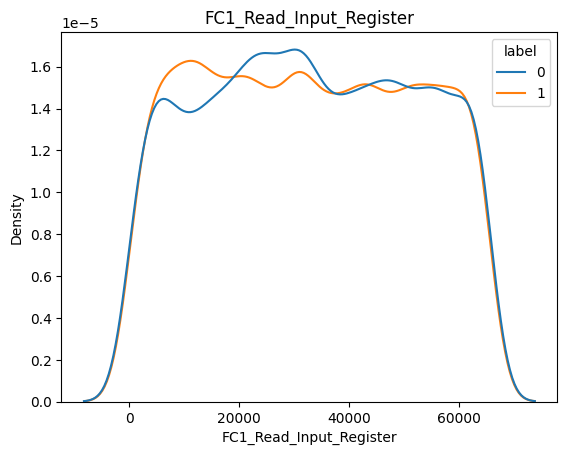

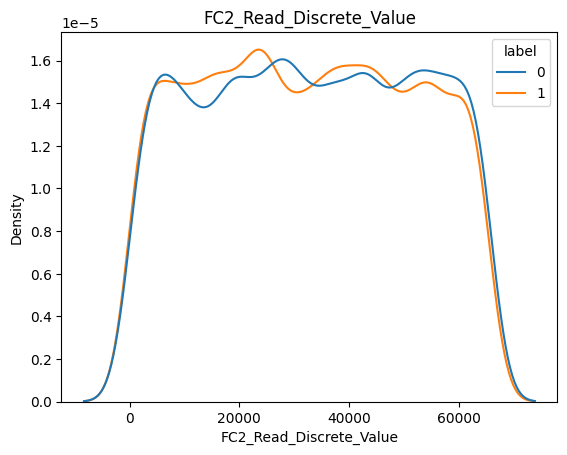

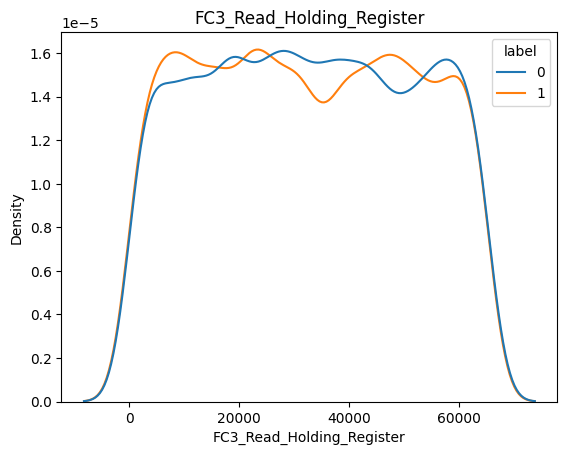

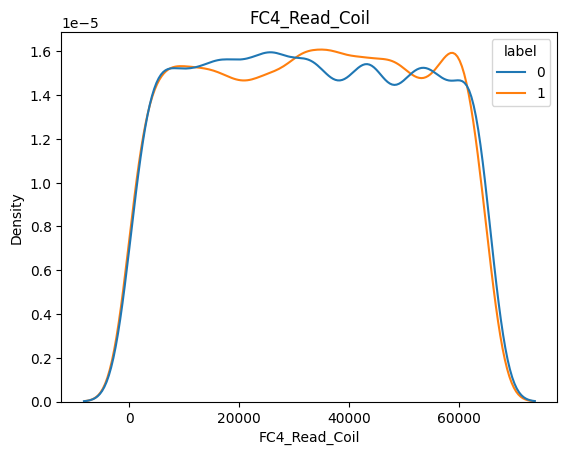

In [61]:
for col in features:
    sns.kdeplot(data=df, x=col, hue="label", common_norm=False)
    plt.title(col)
    plt.show()

#### Results and implications of the exploratory analysis

The class-conditional summary statistics show that the four Modbus counters behave very similarly for normal and attack records. For each feature, the mean, standard deviation and median are almost identical across `label = 0` (normal) and `label = 1` (attack). The correlation matrix also reveals no strong linear relationships among the four counters.

Kernel density plots confirm this picture: the empirical distributions of the four counters for normal and malicious traffic almost perfectly overlap, with only very small shifts in certain regions of the range.

These observations suggest that **instantaneous values of the four Modbus counters carry very limited discriminative signal** for distinguishing normal from malicious traffic. Any simple rule- or threshold-based detector built solely on these variables would therefore be unreliable and highly sensitive to noise.

For the purposes of this work, this has two main consequences:

1. It justifies the use of **multivariate ML models (Decision Trees, Random Forests, SVM)** as baseline IDS approaches, since they can at least exploit subtle non-linear interactions between the counters instead of relying on naive thresholds.

2. It highlights an important limitation of the current feature space: the four counters represent a very coarse view of Modbus activity. In future work, it would be natural to enrich the feature set with temporal aggregates (e.g., sliding-window statistics, deltas between consecutive readings, or ratios between function codes) and, ultimately, to move towards richer telemetry beyond these aggregated counters. However, such feature engineering is beyond the scope of the present phase and is left as a direction for further research.


## 2. Data preparation and Train/validation/test splitting

The exploratory analysis of the Modbus function-code counters showed that their marginal distributions are very similar for normal and attack records, and that simple threshold-based rules on individual counters would be unreliable. In spite of this limited discriminative power, these four counters are the only numeric features available in the `Train_Test_IoT_Modbus` subset and therefore constitute the natural starting point for a baseline ML-based IDS.

In this step, I formalise the two prediction tasks considered in Phase 1:

1. **Binary intrusion detection**

   - **Input features:** the four Modbus counters  
     (`FC1_Read_Input_Register`, `FC2_Read_Discrete_Value`,  
     `FC3_Read_Holding_Register`, `FC4_Read_Coil`)
   - **Target variable:** `label`  
     (`0 = normal`, `1 = attack`)

2. **Multiclass intrusion classification**

   - **Input features:** the same four Modbus counters  
   - **Target variable:** `type`, which distinguishes between normal traffic and
     the five Modbus attack categories (`injection`, `backdoor`, `password`,
     `scanning`, `xss`).

The `date` and `time` columns are treated as metadata and are not used as predictors in this phase. For both tasks, I create a three-way split of the dataset into training, validation, and test sets with a 60% / 20% / 20% ratio. The split is **stratified on the multiclass labels** (`type`) so that all traffic and attack categories are represented in each subset with approximately the same proportions. This ensures that the validation and test metrics are meaningful for all classes, including the minority attacks (`scanning` and `xss`).


In [62]:
# 2.1 Define feature matrix (X): the four Modbus counters
feature_cols = [
    "FC1_Read_Input_Register",
    "FC2_Read_Discrete_Value",
    "FC3_Read_Holding_Register",
    "FC4_Read_Coil",
]

X = df[feature_cols].copy()   # DataFrame, conserva nombres

In [63]:
# 2.2 Define target vectors: binary label and multi-class attack type

# Binary target: normal (0) vs attack (1)
y_binary = df["label"].astype(int).to_numpy()

type_encoder = LabelEncoder()
y_multiclass = type_encoder.fit_transform(df["type"])

# Keep class names for later reporting/plots
class_names = type_encoder.classes_
class_names

print("Multiclass classes:", class_names)

Multiclass classes: ['backdoor' 'injection' 'normal' 'password' 'scanning' 'xss']


In order to analyse the behaviour of the models under different operational assumptions, I define two separate target vectors:

- A **binary label** (`y_binary`), derived from the `label` column, which distinguishes between *normal* (`0`) and *attack* (`1`) records.

- A **multi-class label** (`y_multiclass`), obtained by encoding the `type` column (values such as `normal`, `injection`, `backdoor`, `password`, `scanning`, `xss`) with a `LabelEncoder`.

In [64]:
# 2.3 Helper to summarise class distributions
def summarize_distribution(name, y_encoded):
    """
    Print the class distribution for a given split.
    y_encoded is the integer-encoded multi-class label.
    """
    counts = pd.Series(y_encoded).value_counts().sort_index()
    print(f"\n{name} class distribution (index = encoded label):")
    for idx, count in counts.items():
        print(f"  {idx} ({class_names[idx]}): {count}")

# Distribution on the full dataset (sanity check)
summarize_distribution("Full dataset", y_multiclass)


Full dataset class distribution (index = encoded label):
  0 (backdoor): 5000
  1 (injection): 5000
  2 (normal): 15000
  3 (password): 5000
  4 (scanning): 529
  5 (xss): 577


In [65]:
# 2.4 Train / Validation / Test split 60 / 20 / 20

# First: split off 20% as final test set
X_temp, X_test, y_binary_temp, y_binary_test, y_multi_temp, y_multi_test = train_test_split(
    X,
    y_binary,
    y_multiclass,
    test_size=0.2,
    stratify=y_multiclass,   # stratify by multi-class labels
    random_state=42,
)

# Second: from remaining 80%, take 25% as validation (0.25 * 0.8 = 0.2 total)
X_train, X_val, y_binary_train, y_binary_val, y_multi_train, y_multi_val = train_test_split(
    X_temp,
    y_binary_temp,
    y_multi_temp,
    test_size=0.25,
    stratify=y_multi_temp,   # keep stratification
    random_state=42,
)

print("\nShapes:")
print("  X_train:", X_train.shape)
print("  X_val  :", X_val.shape)
print("  X_test :", X_test.shape)

# Check class distributions in each split
summarize_distribution("Train split", y_multi_train)
summarize_distribution("Validation split", y_multi_val)
summarize_distribution("Test split", y_multi_test)


Shapes:
  X_train: (18663, 4)
  X_val  : (6221, 4)
  X_test : (6222, 4)

Train split class distribution (index = encoded label):
  0 (backdoor): 3000
  1 (injection): 3000
  2 (normal): 9000
  3 (password): 3000
  4 (scanning): 317
  5 (xss): 346

Validation split class distribution (index = encoded label):
  0 (backdoor): 1000
  1 (injection): 1000
  2 (normal): 3000
  3 (password): 1000
  4 (scanning): 106
  5 (xss): 115

Test split class distribution (index = encoded label):
  0 (backdoor): 1000
  1 (injection): 1000
  2 (normal): 3000
  3 (password): 1000
  4 (scanning): 106
  5 (xss): 116


In [66]:
# 2.5 Cross-validation splitter for later model tuning

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42,
)

print("\nStratifiedKFold configured with 5 folds on the training set.")


StratifiedKFold configured with 5 folds on the training set.


### Train–validation–test partition (60 / 20 / 20)

After defining the feature matrix `X` (the four Modbus function-code counters) and the two target vectors (`y_binary` and `y_multiclass`), I partition the `Train_Test_IoT_Modbus` subset into three disjoint sets:

- **60% training set** (`X_train`), used to fit the models and to run stratified 5-fold cross-validation for hyperparameter tuning.
- **20% validation set** (`X_val`), used to compare different model families and to inspect confusion patterns and performance per attack category under realistic conditions.
- **20% test set** (`X_test`), held out from the beginning and used only once for the final assessment of generalisation performance.

The partition is computed in two steps. First, 20% of the data are reserved as a final test set. Then, from the remaining 80%, 25% are taken as validation data, resulting in the desired 60/20/20 ratio. Both steps are **stratified by the multi-class `y_multiclass` label**, so that the relative frequency of each traffic category (`normal`, `backdoor`, `injection`, `password`, `scanning`, `xss`) is approximately preserved in all three sets.

The class-count tables printed above show that all categories remain represented in train, validation and test splits (e.g. about 9 000 normal and 3 000 samples per major attack type in `X_train`, and more than 100 samples for the rarer `scanning` and `xss` classes in both `X_val` and `X_test`). This avoids degenerate situations where some attack types would be absent from the evaluation sets and also makes the underlying class imbalance explicit.

For model selection, hyperparameter tuning is restricted to `X_train` using **stratified 5-fold cross-validation**. The validation set `X_val` is then used to compare the tuned models and to calibrate decision thresholds if needed, while the test set `X_test` remains untouched until the very end of the analysis, providing an unbiased estimate of generalisation performance.



## 3. Feature preprocessing: standardising the Modbus counters

The four Modbus function-code counters have similar ranges and are all expressed as integer counts, but their absolute magnitudes are still large (between 0 and ~65,000) and highly variable. Tree-based models such as Decision Trees and Random Forests are relatively insensitive to feature scaling, but Support Vector Machines with an RBF kernel are not: they rely on distances in feature space, and unscaled features can distort these distances.

To keep the comparison fair and to make the optimisation landscape more stable for SVMs, I standardise all four Modbus features to zero mean and unit variance:

- The scaler is **fitted on the training set only**,  
- and then **applied to the validation and test sets**,  
  in order to avoid information leakage from future data into the training process.

The target vectors (`y_binary` and `y_multiclass`) are left unchanged.


In [67]:
# 3.1 Instantiate the scaler
scaler = StandardScaler()

# 3.2 Fit on training data only, then transform all splits
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

print("Scaled shapes:")
print("  X_train_scaled:", X_train_scaled.shape)
print("  X_val_scaled  :", X_val_scaled.shape)
print("  X_test_scaled :", X_test_scaled.shape)

Scaled shapes:
  X_train_scaled: (18663, 4)
  X_val_scaled  : (6221, 4)
  X_test_scaled : (6222, 4)


In [68]:
print("\nTraining means after scaling (should be ~0):")
print(np.mean(X_train_scaled, axis=0))

print("\nTraining stds after scaling (should be ~1):")
print(np.std(X_train_scaled, axis=0))


Training means after scaling (should be ~0):
[ 1.10790300e-16 -3.73108225e-17 -2.89349236e-17 -1.92645676e-16]

Training stds after scaling (should be ~1):
[1. 1. 1. 1.]


### 4. Model training and hyperparameter tuning

In this step I train and tune three classical ML models that are widely used for tabular intrusion detection problems:

- **Decision Trees (DT)**
- **Random Forests (RF)**
- **Support Vector Machines (SVM)**

Each model is evaluated on two prediction tasks:

1. **Binary intrusion detection** (`label`: normal vs. attack)
2. **Multiclass intrusion classification** (`type`: normal + five attack categories)

Hyperparameter tuning is performed using **stratified 5-fold cross-validation on the training set**, with macro-averaged F1-score as the optimisation criterion, in order to give equal weight to all classes (including the minority attack types). The separate validation set is then used to compare the tuned models and to analyse their behaviour per class, especially in terms of false negatives.

All models operate on the same four Modbus counters (after standardisation), so any difference in performance is due to the learning algorithm and not to differences in input features.


In [72]:
# 4.1 Aliases for scaled features

Xtr = X_train_scaled
Xva = X_val_scaled

# Binary class names (for reports)
class_names_binary = np.array(["normal", "attack"])
labels_binary = np.array([0, 1])

# Multiclass labels (already encoded 0..K-1)
labels_multi = np.arange(len(class_names))   # class_names comes from LabelEncoder

# 5-fold stratified CV on the training set
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


In [73]:
# 4.2 Helper functions
# -------------------------------

def tune_model(
    estimator,
    param_grid,
    X_train,
    y_train,
    cv,
    model_name,
    task_name,
    scoring="f1_macro",
):
    """
    Run GridSearchCV with the chosen scoring metric and return the best estimator.
    """
    print(f"\n===== Tuning {model_name} ({task_name}) =====")
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        verbose=1,
    )
    grid.fit(X_train, y_train)
    print(f"Best params: {grid.best_params_}")
    print(f"Best CV {scoring}: {grid.best_score_:.4f}")
    return grid.best_estimator_


def evaluate_on_validation(
    model,
    X_val,
    y_val,
    class_names,
    labels,
    model_name,
    task_name,
):
    """
    Evaluate a trained model on the validation set and print detailed metrics,
    including macro-F1, weighted-F1, and per-class FNR/FPR.
    """
    print(f"\n----- Validation performance for {model_name} ({task_name}) -----")
    y_pred = model.predict(X_val)

    # Classification report (forces consistent label order)
    print(
        classification_report(
            y_val,
            y_pred,
            labels=labels,
            target_names=class_names,
            digits=4,
            zero_division=0,
        )
    )

    # Confusion matrix with the same label order
    cm = confusion_matrix(y_val, y_pred, labels=labels)

    # Macro and weighted F1
    macro_f1 = f1_score(y_val, y_pred, average="macro")
    weighted_f1 = f1_score(y_val, y_pred, average="weighted")

    print(f"Macro-F1:    {macro_f1:.4f}")
    print(f"Weighted-F1: {weighted_f1:.4f}")

    # False Negative Rate (FNR) per class
    fnr_per_class = {}
    fpr_per_class = {}

    for idx, cls in enumerate(class_names):
        tp = cm[idx, idx]
        fn = cm[idx, :].sum() - tp
        fp = cm[:, idx].sum() - tp
        tn = cm.sum() - (tp + fn + fp)

        fnr = fn / (tp + fn) if (tp + fn) > 0 else 0.0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0.0

        fnr_per_class[cls] = fnr
        fpr_per_class[cls] = fpr

    print("\nFalse Negative Rate (missed attacks) per class:")
    for cls, fnr in fnr_per_class.items():
        print(f"  {cls}: {fnr:.4f}")

    print("\nFalse Positive Rate (false alarms) per class:")
    for cls, fpr in fpr_per_class.items():
        print(f"  {cls}: {fpr:.4f}")

    return {
        "cm": cm,
        "macro_f1": macro_f1,
        "weighted_f1": weighted_f1,
        "fnr": fnr_per_class,
        "fpr": fpr_per_class,
    }

In [74]:
# 4.3 Hyperparameter grids

# Grids moderados; si el tiempo de cómputo es alto, reduce combinaciones

dt_param_grid = {
    "max_depth": [None, 5, 10, 15],
    "min_samples_leaf": [1, 2, 4],
}

rf_param_grid = {
    "n_estimators": [100, 300],
    "max_depth": [None, 10, 20],
    "min_samples_leaf": [1, 2],
}

svm_param_grid = {
    "C": [0.1, 1, 10],
    "gamma": ["scale", 0.01, 0.001],
    "kernel": ["rbf"],
}

In [76]:
# 4.4 Binary classification: normal vs attack

# Decision Tree (binary)
dt_bin = tune_model(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=dt_param_grid,
    X_train=Xtr,
    y_train=y_binary_train,
    cv=cv,
    model_name="Decision Tree",
    task_name="binary",
    scoring="f1",  # focus on label: 1 = attack
)

res_dt_bin = evaluate_on_validation(
    model=dt_bin,
    X_val=Xva,
    y_val=y_binary_val,
    class_names=class_names_binary,
    labels=labels_binary,
    model_name="Decision Tree",
    task_name="binary",
)


===== Tuning Decision Tree (binary) =====
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'max_depth': None, 'min_samples_leaf': 1}
Best CV f1: 0.9085

----- Validation performance for Decision Tree (binary) -----
              precision    recall  f1-score   support

      normal     0.9279    0.9563    0.9419      3000
      attack     0.9581    0.9308    0.9443      3221

    accuracy                         0.9431      6221
   macro avg     0.9430    0.9436    0.9431      6221
weighted avg     0.9435    0.9431    0.9431      6221

Macro-F1:    0.9431
Weighted-F1: 0.9431

False Negative Rate (missed attacks) per class:
  normal: 0.0437
  attack: 0.0692

False Positive Rate (false alarms) per class:
  normal: 0.0692
  attack: 0.0437


In [78]:
# Random Forest (binary)
rf_bin = tune_model(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    X_train=Xtr,
    y_train=y_binary_train,
    cv=cv,
    model_name="Random Forest",
    task_name="binary",
    scoring="f1",
)

res_rf_bin = evaluate_on_validation(
    model=rf_bin,
    X_val=Xva,
    y_val=y_binary_val,
    class_names=class_names_binary,
    labels=labels_binary,
    model_name="Random Forest",
    task_name="binary",
)


===== Tuning Random Forest (binary) =====
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 300}
Best CV f1: 0.9150

----- Validation performance for Random Forest (binary) -----
              precision    recall  f1-score   support

      normal     0.9374    0.9533    0.9453      3000
      attack     0.9558    0.9407    0.9482      3221

    accuracy                         0.9468      6221
   macro avg     0.9466    0.9470    0.9468      6221
weighted avg     0.9469    0.9468    0.9468      6221

Macro-F1:    0.9468
Weighted-F1: 0.9468

False Negative Rate (missed attacks) per class:
  normal: 0.0467
  attack: 0.0593

False Positive Rate (false alarms) per class:
  normal: 0.0593
  attack: 0.0467


In [77]:
# SVM RBF (binary)
svm_bin = tune_model(
    estimator=SVC(),
    param_grid=svm_param_grid,
    X_train=Xtr,
    y_train=y_binary_train,
    cv=cv,
    model_name="SVM RBF",
    task_name="binary",
    scoring="f1",
)

res_svm_bin = evaluate_on_validation(
    model=svm_bin,
    X_val=Xva,
    y_val=y_binary_val,
    class_names=class_names_binary,
    labels=labels_binary,
    model_name="SVM RBF",
    task_name="binary",
)


===== Tuning SVM RBF (binary) =====
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params: {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
Best CV f1: 0.6823

----- Validation performance for SVM RBF (binary) -----
              precision    recall  f1-score   support

      normal     0.0000    0.0000    0.0000      3000
      attack     0.5178    1.0000    0.6823      3221

    accuracy                         0.5178      6221
   macro avg     0.2589    0.5000    0.3411      6221
weighted avg     0.2681    0.5178    0.3533      6221

Macro-F1:    0.3411
Weighted-F1: 0.3533

False Negative Rate (missed attacks) per class:
  normal: 1.0000
  attack: 0.0000

False Positive Rate (false alarms) per class:
  normal: 0.0000
  attack: 1.0000


In [79]:
# 4.5 Multiclass classification: traffic type

# Decision Tree (multiclass)
dt_multi = tune_model(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=dt_param_grid,
    X_train=Xtr,
    y_train=y_multi_train,
    cv=cv,
    model_name="Decision Tree",
    task_name="multiclass",
    scoring="f1_macro",
)

res_dt_multi = evaluate_on_validation(
    model=dt_multi,
    X_val=Xva,
    y_val=y_multi_val,
    class_names=class_names,
    labels=labels_multi,
    model_name="Decision Tree",
    task_name="multiclass",
)


===== Tuning Decision Tree (multiclass) =====
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'max_depth': None, 'min_samples_leaf': 1}
Best CV f1_macro: 0.7686

----- Validation performance for Decision Tree (multiclass) -----
              precision    recall  f1-score   support

    backdoor     0.9198    0.8830    0.9010      1000
   injection     0.9009    0.9360    0.9181      1000
      normal     0.9306    0.9610    0.9456      3000
    password     0.8967    0.8590    0.8774      1000
    scanning     0.8056    0.5472    0.6517       106
         xss     0.7979    0.6522    0.7177       115

    accuracy                         0.9153      6221
   macro avg     0.8752    0.8064    0.8352      6221
weighted avg     0.9140    0.9153    0.9138      6221

Macro-F1:    0.8352
Weighted-F1: 0.9138

False Negative Rate (missed attacks) per class:
  backdoor: 0.1170
  injection: 0.0640
  normal: 0.0390
  password: 0.1410
  scanning: 0.4528
  xss: 0.3478

Fal

In [80]:
# Random Forest (multiclass)
rf_multi = tune_model(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=rf_param_grid,
    X_train=Xtr,
    y_train=y_multi_train,
    cv=cv,
    model_name="Random Forest",
    task_name="multiclass",
    scoring="f1_macro",
)

res_rf_multi = evaluate_on_validation(
    model=rf_multi,
    X_val=Xva,
    y_val=y_multi_val,
    class_names=class_names,
    labels=labels_multi,
    model_name="Random Forest",
    task_name="multiclass",
)


===== Tuning Random Forest (multiclass) =====
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 100}
Best CV f1_macro: 0.8040

----- Validation performance for Random Forest (multiclass) -----
              precision    recall  f1-score   support

    backdoor     0.9530    0.8710    0.9101      1000
   injection     0.9406    0.9180    0.9291      1000
      normal     0.8819    0.9787    0.9278      3000
    password     0.9543    0.8350    0.8907      1000
    scanning     1.0000    0.5094    0.6750       106
         xss     1.0000    0.6348    0.7766       115

    accuracy                         0.9142      6221
   macro avg     0.9550    0.7911    0.8516      6221
weighted avg     0.9186    0.9142    0.9121      6221

Macro-F1:    0.8516
Weighted-F1: 0.9121

False Negative Rate (missed attacks) per class:
  backdoor: 0.1290
  injection: 0.0820
  normal: 0.0213
  password: 0.1650
  scanning: 0.49

In [81]:
# SVM RBF (multiclass)
svm_multi = tune_model(
    estimator=SVC(),
    param_grid=svm_param_grid,
    X_train=Xtr,
    y_train=y_multi_train,
    cv=cv,
    model_name="SVM RBF",
    task_name="multiclass",
    scoring="f1_macro",
)

res_svm_multi = evaluate_on_validation(
    model=svm_multi,
    X_val=Xva,
    y_val=y_multi_val,
    class_names=class_names,
    labels=labels_multi,
    model_name="SVM RBF",
    task_name="multiclass",
)


===== Tuning SVM RBF (multiclass) =====
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV f1_macro: 0.1087

----- Validation performance for SVM RBF (multiclass) -----
              precision    recall  f1-score   support

    backdoor     0.0000    0.0000    0.0000      1000
   injection     0.0000    0.0000    0.0000      1000
      normal     0.4824    1.0000    0.6508      3000
    password     0.0000    0.0000    0.0000      1000
    scanning     0.0000    0.0000    0.0000       106
         xss     0.0000    0.0000    0.0000       115

    accuracy                         0.4822      6221
   macro avg     0.0804    0.1667    0.1085      6221
weighted avg     0.2326    0.4822    0.3139      6221

Macro-F1:    0.1085
Weighted-F1: 0.3139

False Negative Rate (missed attacks) per class:
  backdoor: 1.0000
  injection: 1.0000
  normal: 0.0000
  password: 1.0000
  scanning: 1.0000
  xss: 1.0000

False Positive Rate (false alarms) per class:
  backdoor: 0.0000
  injection: 0.0000
  normal: 0.9994
  password: 0